In [1]:
import os
import sys
sys.path.append(os.getcwd())
import torch
import argparse
from model.deeplab import *
from tqdm import tqdm
import json
from utils.metrics import Evaluator
from data import spacenet
from common import config
from torch.utils.data import DataLoader
import numpy as np
import cv2
import torchvision
import matplotlib.pyplot as plt
import torch.nn
from model.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

#### source and target domain

In [22]:
source_n = 'Khartoum'
target_n = 'Paris'

# source domain model
model_path_s = '/home/home1/xw176/work/Domain_Adaptation/configs/mobilenet.baseline/xh.deeplab.mobilenet.'+ source_n.lower()+'.n/train_log/best.pth'
# target domain model
model_path_t = '/home/home1/xw176/work/Domain_Adaptation/configs/mobilenet.baseline/xh.deeplab.mobilenet.'+target_n.lower()+'.n/train_log/best.pth'

cuda = True
# bn = False

#### load models

In [23]:
source_set = spacenet.Spacenet(city=source_n, split='test', img_root=config.img_root)
source_loader = DataLoader(source_set, batch_size=config.batch_size, shuffle=False, num_workers=2, drop_last=True)
target_set = spacenet.Spacenet(city=target_n, split='train', img_root=config.img_root)
target_loader = DataLoader(target_set, batch_size=config.batch_size, shuffle=False, num_workers=2, drop_last=True)
target_set_test = spacenet.Spacenet(city=target_n, split='test', img_root=config.img_root)
target_loader_test = DataLoader(target_set, batch_size=config.batch_size, shuffle=False, num_workers=2, drop_last=True)

model_s = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=True)
model_s_ada = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=False)
model_t = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=True)

if cuda:
    checkpoint_s = torch.load(model_path_s)
    checkpoint_s_ada = torch.load(model_path_s)
    checkpoint_t = torch.load(model_path_t)
else:
    checkpoint_s = torch.load(model_path_s, map_location=torch.device('cpu'))
    checkpoint_s_ada = torch.load(model_path_s, map_location=torch.device('cpu'))
    checkpoint_t = torch.load(model_path_t, map_location=torch.device('cpu'))
    
model_s.load_state_dict(checkpoint_s)
model_s_ada.load_state_dict(checkpoint_s_ada)
model_t.load_state_dict(checkpoint_t)

# evaluator = Evaluator(2)
if cuda:
    model_s = model_s.cuda()
    model_t = model_t.cuda()
    model_s_ada = model_s_ada.cuda()
model_s.eval();
model_t.eval();
model_s_ada.eval();

Found 180 test images
Found 360 train images
Found 120 test images


#### compare mean and var before and after adabn

In [24]:
mean_s, var_s = [], []
mean_t, var_t = [], []
mean_s_ada, var_s_ada = [], []


for m in model_s.modules():
    if isinstance(m, SynchronizedBatchNorm2d) or isinstance(m, nn.BatchNorm2d):
        mean_s.append(m.running_mean)
        var_s.append(m.running_var)
        
# for k in model_t.modules():
#     if isinstance(k, SynchronizedBatchNorm2d) or isinstance(k, nn.BatchNorm2d):
#         mean_t.append(k.running_mean)
#         var_t.append(k.running_var)
        
# adabn to update bn parameters on source model
mean_s_ada, var_s_ada = [], []
model_s_ada.train()

# is_first = True
# for m in model_s_ada.modules():
#     if isinstance(m, SynchronizedBatchNorm2d) or isinstance(m, nn.BatchNorm2d):
#         if is_first:
#             is_first = False
#         else:
#             m.eval()

# for i in range(5):
for sample in target_loader:
    image, target = sample['image'], sample['label']
    if cuda:
        image, target = image.cuda(), target.cuda()
    with torch.no_grad():
        output = model_s_ada(image)[0]
for h in model_s_ada.modules():
    if isinstance(h, SynchronizedBatchNorm2d) or isinstance(h, nn.BatchNorm2d):
        mean_s_ada.append(h.running_mean)
        var_s_ada.append(h.running_var)

### reuslt
#### bn parameters of source and target domain

S: Khartoum T: Paris layer 0 : 32


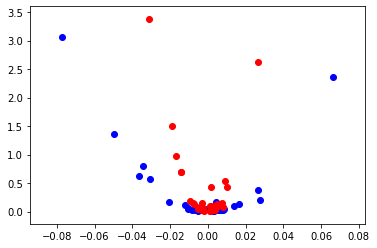

S: Khartoum T: Paris layer 1 : 32


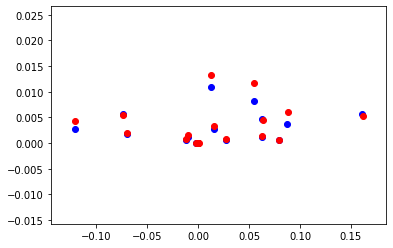

S: Khartoum T: Paris layer 2 : 16


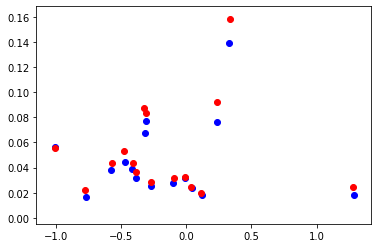

S: Khartoum T: Paris layer 3 : 96


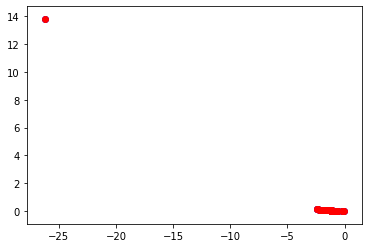

S: Khartoum T: Paris layer 4 : 96


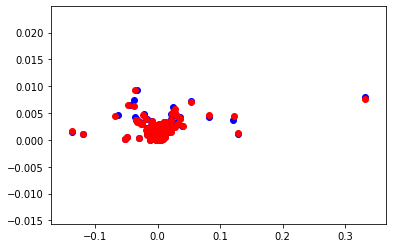

S: Khartoum T: Paris layer 5 : 24


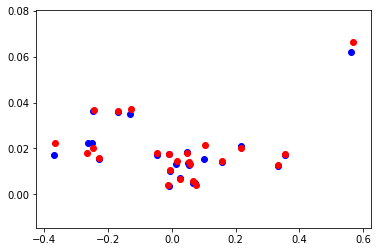

S: Khartoum T: Paris layer 6 : 144


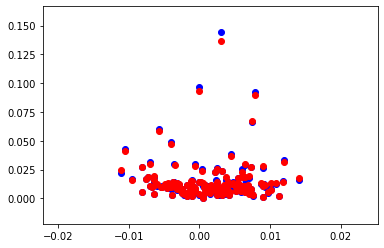

S: Khartoum T: Paris layer 7 : 144


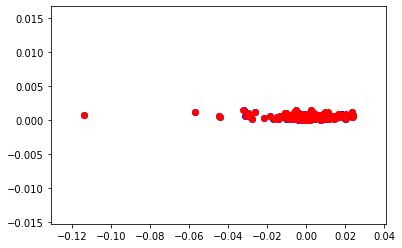

S: Khartoum T: Paris layer 8 : 24


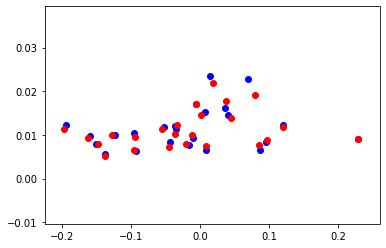

S: Khartoum T: Paris layer 9 : 144


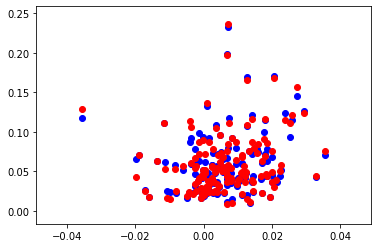

S: Khartoum T: Paris layer 10 : 144


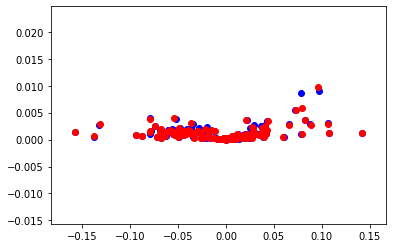

S: Khartoum T: Paris layer 11 : 32


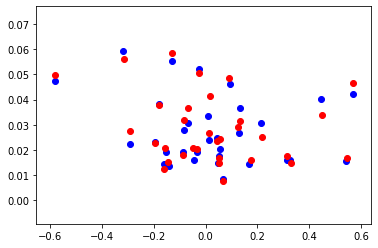

S: Khartoum T: Paris layer 12 : 192


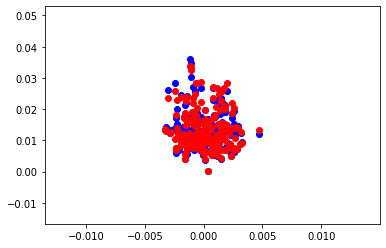

S: Khartoum T: Paris layer 13 : 192


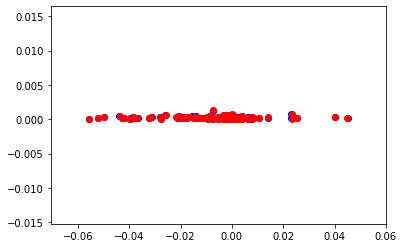

S: Khartoum T: Paris layer 14 : 32


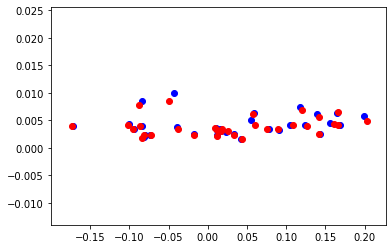

S: Khartoum T: Paris layer 15 : 192


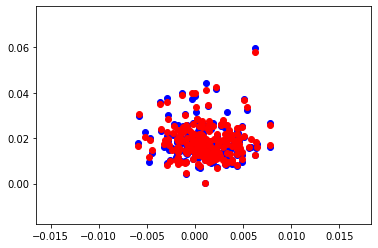

S: Khartoum T: Paris layer 16 : 192


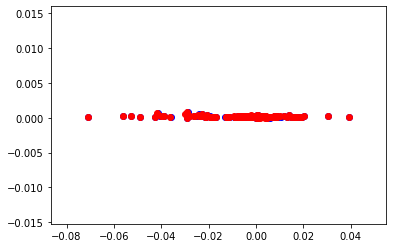

S: Khartoum T: Paris layer 17 : 32


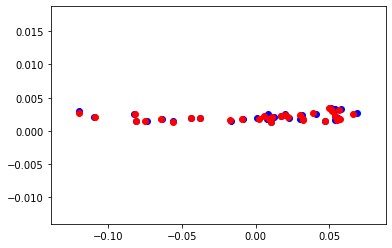

S: Khartoum T: Paris layer 18 : 192


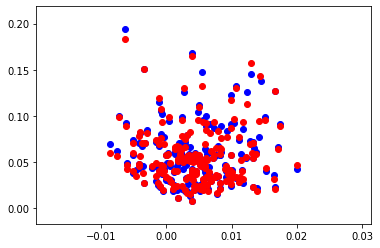

S: Khartoum T: Paris layer 19 : 192


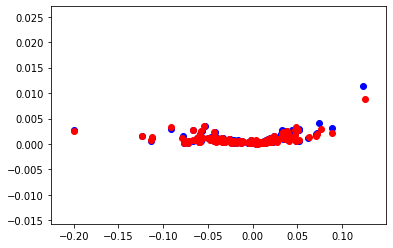

S: Khartoum T: Paris layer 20 : 64


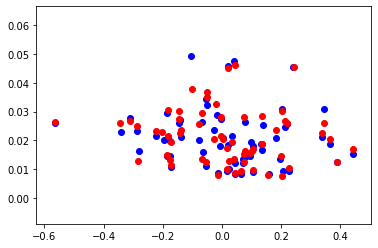

S: Khartoum T: Paris layer 21 : 384


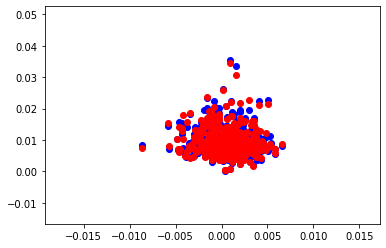

S: Khartoum T: Paris layer 22 : 384


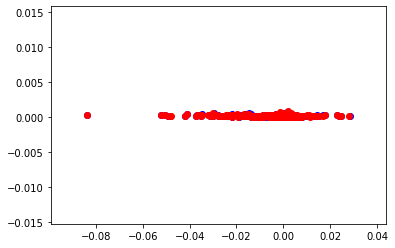

S: Khartoum T: Paris layer 23 : 64


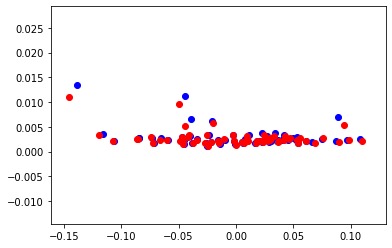

S: Khartoum T: Paris layer 24 : 384


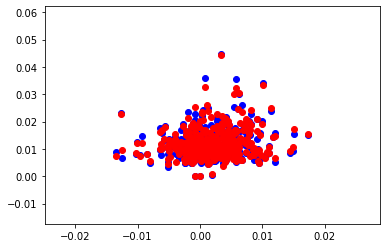

S: Khartoum T: Paris layer 25 : 384


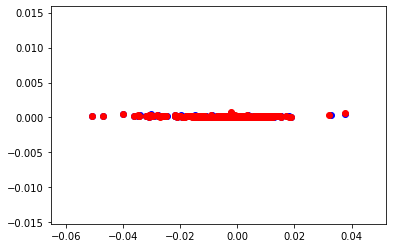

S: Khartoum T: Paris layer 26 : 64


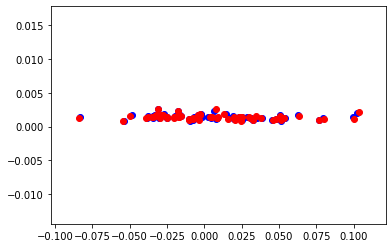

S: Khartoum T: Paris layer 27 : 384


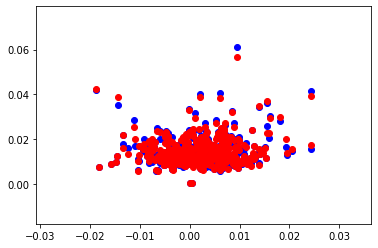

S: Khartoum T: Paris layer 28 : 384


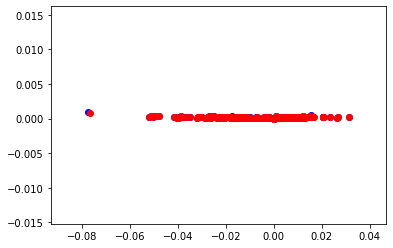

S: Khartoum T: Paris layer 29 : 64


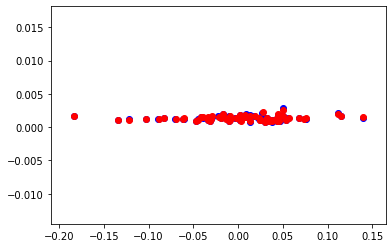

S: Khartoum T: Paris layer 30 : 384


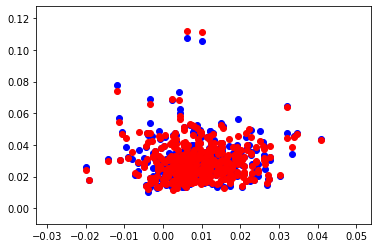

S: Khartoum T: Paris layer 31 : 384


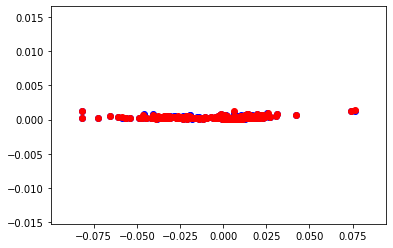

S: Khartoum T: Paris layer 32 : 96


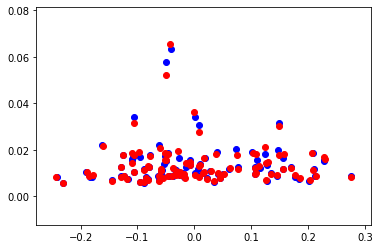

S: Khartoum T: Paris layer 33 : 576


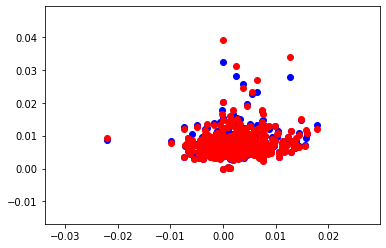

S: Khartoum T: Paris layer 34 : 576


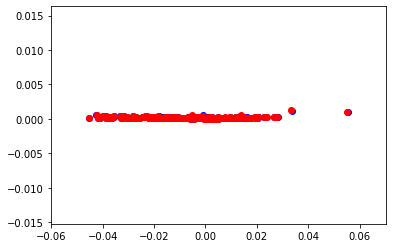

S: Khartoum T: Paris layer 35 : 96


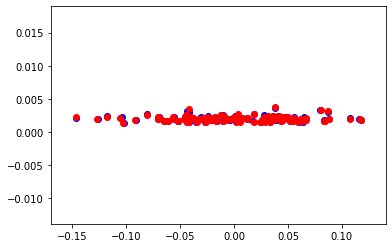

S: Khartoum T: Paris layer 36 : 576


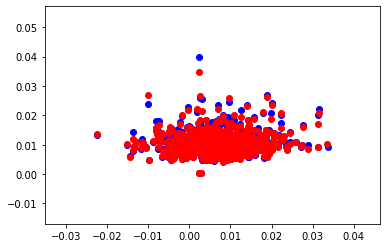

S: Khartoum T: Paris layer 37 : 576


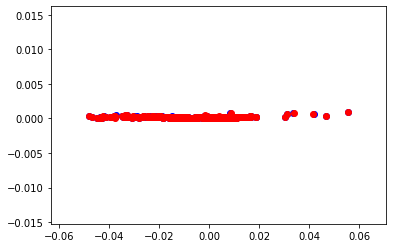

S: Khartoum T: Paris layer 38 : 96


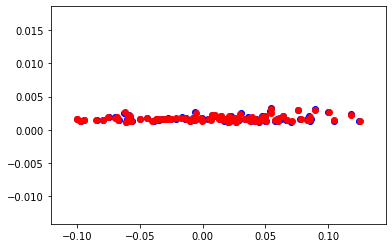

S: Khartoum T: Paris layer 39 : 576


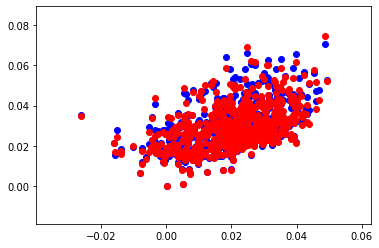

S: Khartoum T: Paris layer 40 : 576


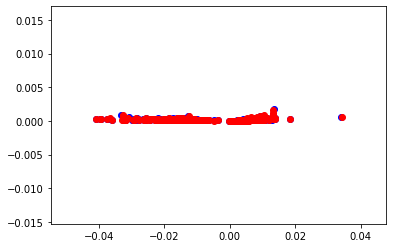

S: Khartoum T: Paris layer 41 : 160


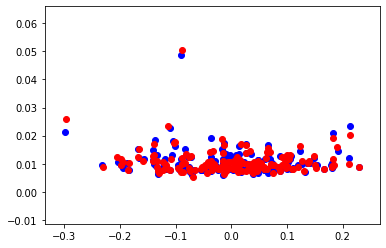

S: Khartoum T: Paris layer 42 : 960


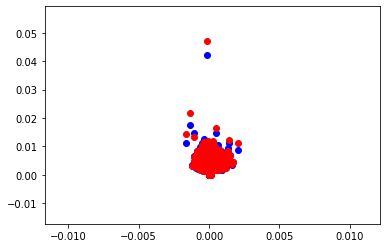

S: Khartoum T: Paris layer 43 : 960


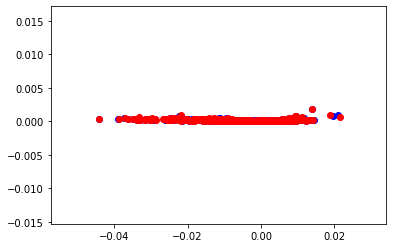

S: Khartoum T: Paris layer 44 : 160


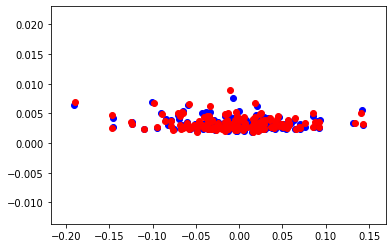

S: Khartoum T: Paris layer 45 : 960


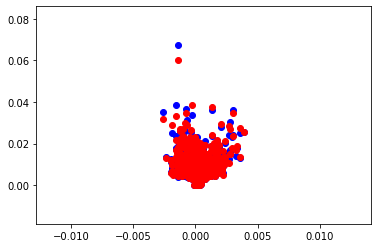

S: Khartoum T: Paris layer 46 : 960


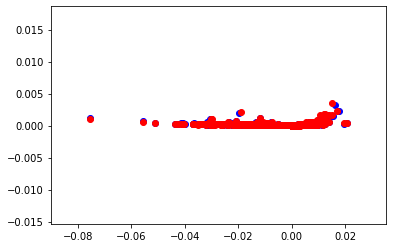

S: Khartoum T: Paris layer 47 : 160


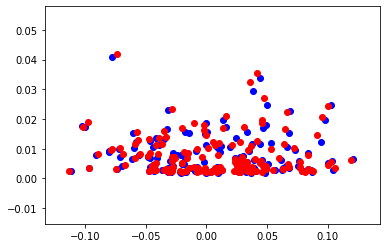

S: Khartoum T: Paris layer 48 : 960


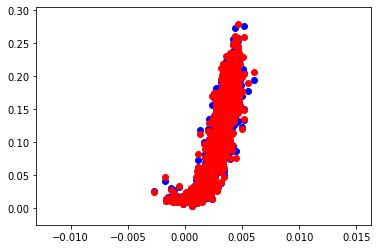

S: Khartoum T: Paris layer 49 : 960


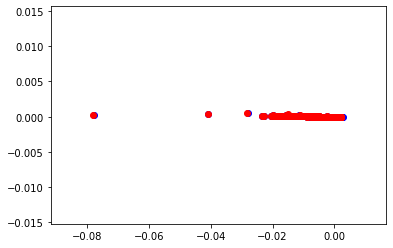

S: Khartoum T: Paris layer 50 : 320


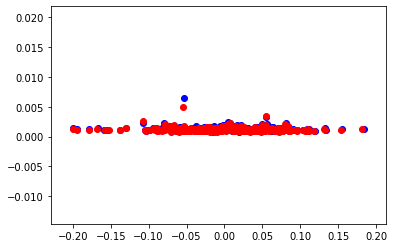

S: Khartoum T: Paris layer 51 : 256


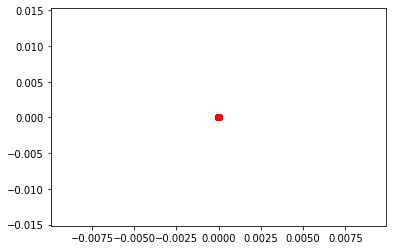

S: Khartoum T: Paris layer 52 : 256


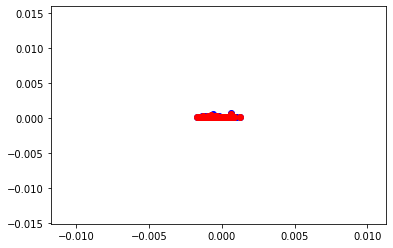

S: Khartoum T: Paris layer 53 : 256


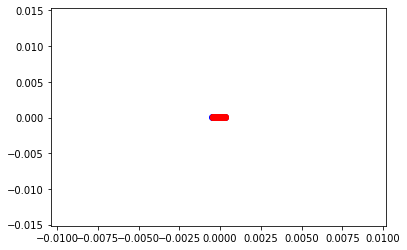

S: Khartoum T: Paris layer 54 : 256


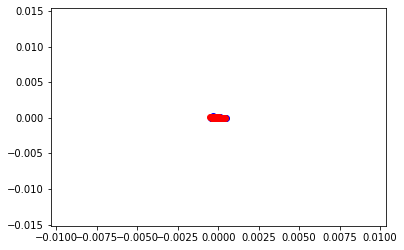

S: Khartoum T: Paris layer 55 : 256


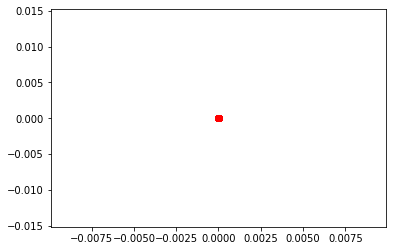

S: Khartoum T: Paris layer 56 : 256


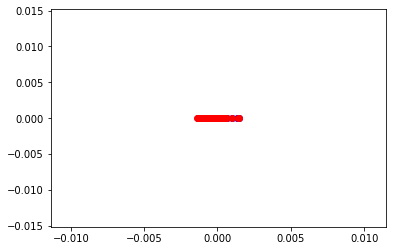

S: Khartoum T: Paris layer 57 : 48


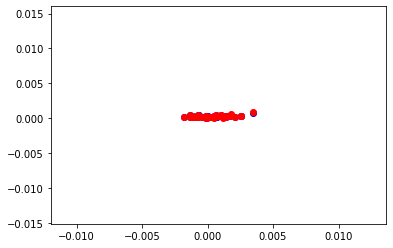

S: Khartoum T: Paris layer 58 : 256


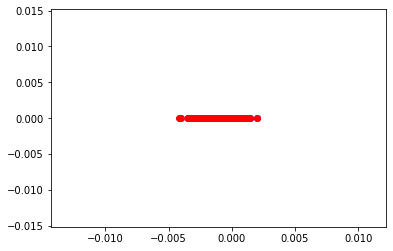

S: Khartoum T: Paris layer 59 : 256


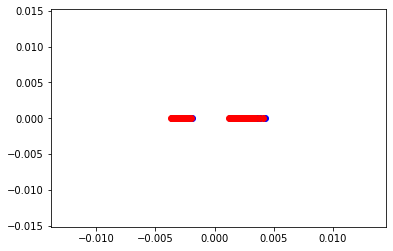

In [25]:
for i in range(len(mean_s_ada)):
    print('S:', source_n, 'T:', target_n, 'layer', i, ':', len(mean_s[i]))
    plt.scatter(mean_s[i].cpu(), var_s[i].cpu(), c='b')
    plt.scatter(mean_s_ada[i].cpu(), var_s_ada[i].cpu(), c='r')
    plt.show()

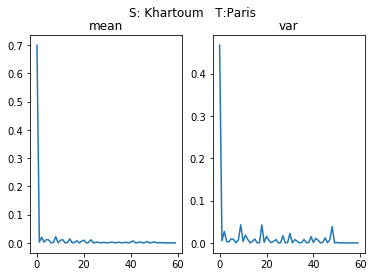

In [25]:
mean_all_diff=[]
var_all_diff=[]
for i in range(len(mean_s)):
    mean_diff = mean_s_ada[i] - mean_s[i]
    index = torch.abs(mean_diff).sort(descending=True)[1]
    mean_all_diff.append(torch.abs(mean_diff[index[0]]))
    var_diff = var_s_ada[i] - var_s[i]
    index = torch.abs(var_diff).sort(descending=True)[1]
    var_all_diff.append(torch.abs(var_diff[index[0]]))
#     print('layer', i, '[mean]: ', mean_diff[index[0]])
#     print('layer', i, '[var]: ', var_diff[index[0]])
fig, axes = plt.subplots(1,2)
axes[0].plot([i for i in range(len(mean_s))], mean_all_diff)
axes[0].set_title('mean')
# axes[0].set_yscale('log')
axes[1].plot([i for i in range(len(mean_s))], var_all_diff)
axes[1].set_title('var')
# axes[1].set_yscale('log')
fig.suptitle('S: ' + source_n + '   T:' + target_n)
# plt.figure(figsize=())
plt.show()

In [9]:
sample_s = iter(source_loader).next()
sample_t = iter(target_loader).next()

image_s, target_s = sample_s['image'], sample_s['label']
image_t, target_t = sample_t['image'], sample_t['label']

if cuda:
    image_s, target_s = image_s.cuda(), target_s.cuda()
    image_t, target_t = image_t.cuda(), target_t.cuda()

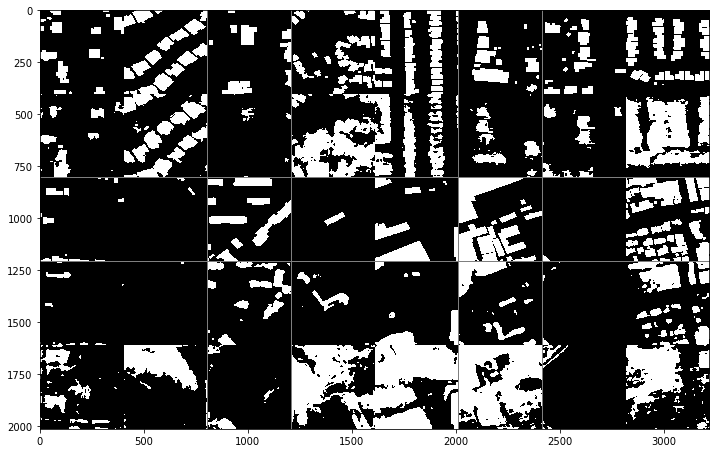

In [13]:
with torch.no_grad():
    # st: source domain model, target domain images
    output_ss = model_s(image_s)[0]
    output_tt = model_t(image_t)[0]
    output_st = model_s(image_t)[0]
pred_ss = torch.argmax(output_ss.data, axis=1).type(torch.float32)
pred_tt = torch.argmax(output_tt.data, axis=1).type(torch.float32)
pred_st = torch.argmax(output_st.data, axis=1).type(torch.float32)

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((target_s, pred_ss, target_t, pred_tt, pred_st), 0).unsqueeze(1), 
                                        config.batch_size, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(12,12))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


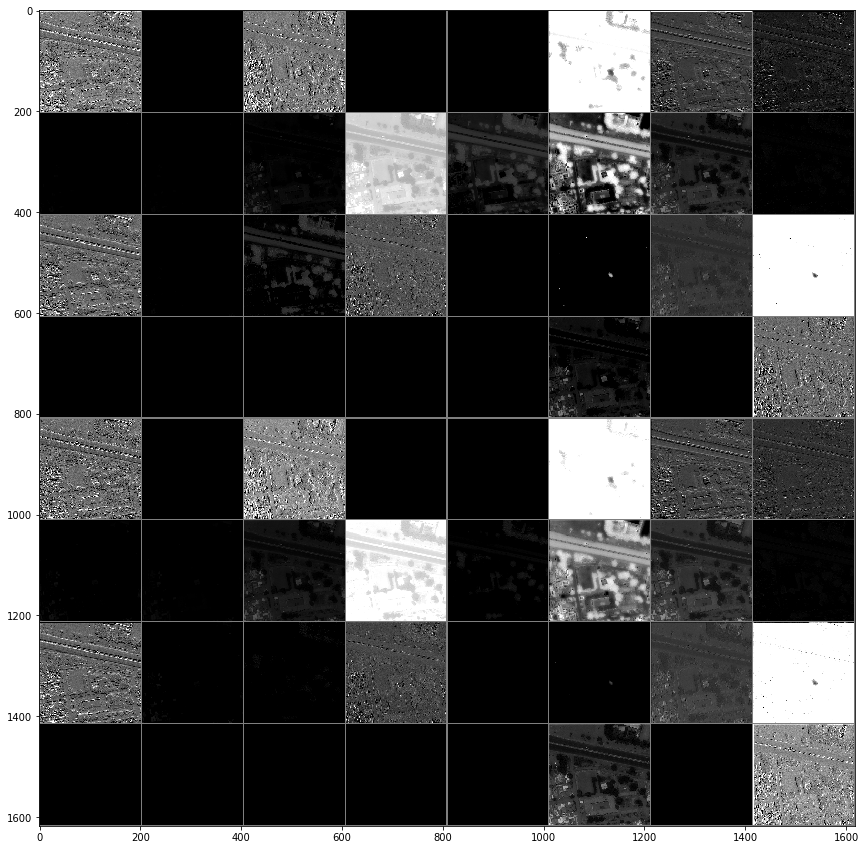

In [14]:
# f0
# f0_m_s_i_s = torch.argmax(f0_m_s_i_s.data, axis=1).type(torch.float32)
# f0_m_s_i_t.shape
f0_m_s_i_t = f0_m_s_i_t.data.permute((1,0,2,3))
f0_m_t_i_t = f0_m_t_i_t.data.permute((1,0,2,3))

# f0_m_s_i_t.shape
batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((f0_m_t_i_t, f0_m_s_i_t), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,15))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


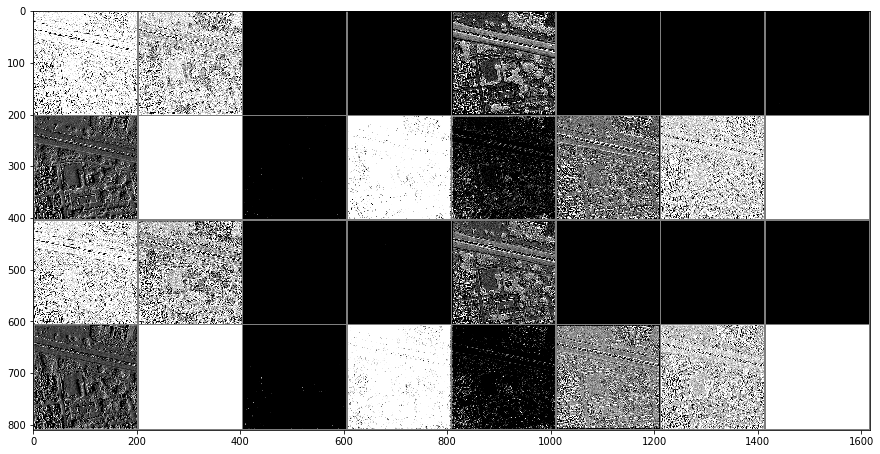

In [15]:
# f1
f1_m_s_i_t = f1_m_s_i_t.data.permute((1,0,2,3))
f1_m_t_i_t = f1_m_t_i_t.data.permute((1,0,2,3))

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((f1_m_t_i_t, f1_m_s_i_t), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,15))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


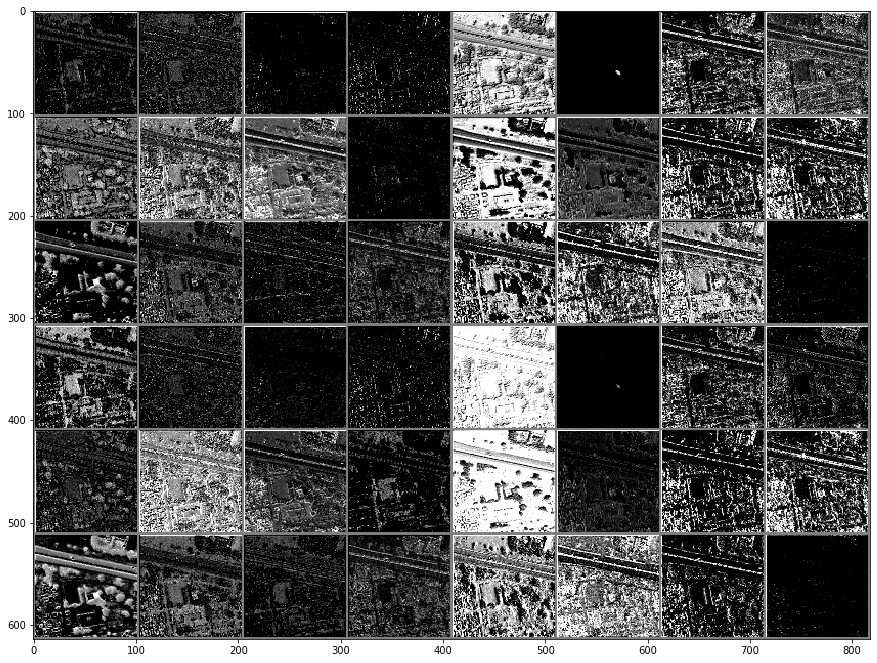

In [16]:
# f2
f2_m_s_i_t = f2_m_s_i_t.data.permute((1,0,2,3))
f2_m_t_i_t = f2_m_t_i_t.data.permute((1,0,2,3))

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((f2_m_t_i_t, f2_m_s_i_t), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,15))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


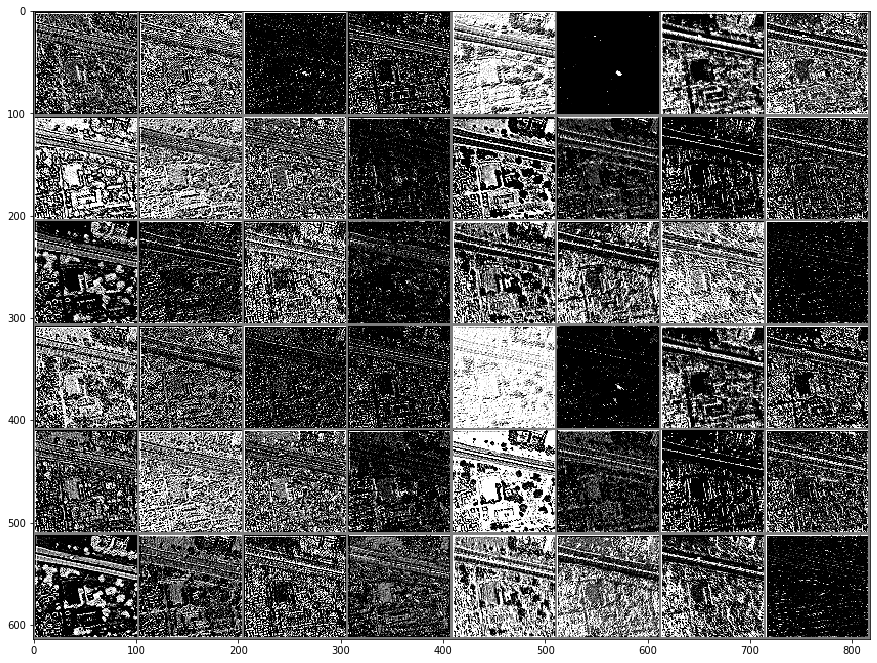

In [17]:
# f3
f3_m_s_i_t = f3_m_s_i_t.data.permute((1,0,2,3))
f3_m_t_i_t = f3_m_t_i_t.data.permute((1,0,2,3))

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((f3_m_t_i_t, f3_m_s_i_t), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,15))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 320, 25, 25])
torch.Size([320, 1, 25, 25])


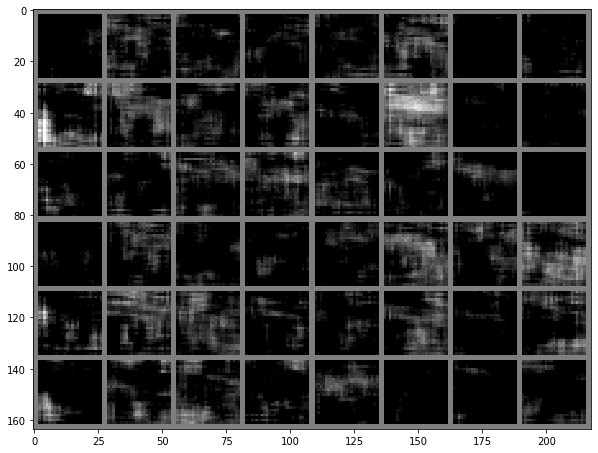

In [26]:
# high_level_feature
print(high_m_t_i_t.shape)
high_m_s_i_t = high_m_s_i_t.data.permute((1,0,2,3))
high_m_t_i_t = high_m_t_i_t.data.permute((1,0,2,3))
print(high_m_t_i_t.shape)

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((high_m_t_i_t[:24, :, :, :], high_m_s_i_t[:24,:,:,:]), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(10,10))
plt.imshow(batch_s1_t2)
plt.show()